# Traffic Signs Classification using ResNet50
(Performance on Google Colaboratory is best using a GPU runtime)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
%matplotlib inline
from tensorflow.keras.utils import plot_model

# Splitting data
from sklearn.model_selection import train_test_split

# Metrics 
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning
import tensorflow as tf
print('TensoFlow Version: ', tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

TensoFlow Version:  2.5.0


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
# !ls -l /kaggle/input/traffic-signs-classification

In [5]:
# path = '/kaggle/input/traffic-signs-classification'
# lab = pd.read_csv('labels.csv')
lab = pd.read_csv('drive/MyDrive/Traffic Signs Classification - data/labels.csv')

## Visualizing countplot of the classes

In [36]:
# Count PLot of the samples/observations w.r.t the classes
d = dict()
class_labels = dict()
# for dirs in os.listdir(path + '/myData'):
for dirs in os.listdir('drive/MyDrive/Traffic Signs Classification - data/myData/myData'):
    # count = len(os.listdir(path+'/myData/'+dirs))
    count = len(os.listdir('drive/MyDrive/Traffic Signs Classification - data/myData/myData/'+dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

# plt.figure(figsize = (20, 50))
# sns.barplot(y = list(d.keys()), x = list(d.values()), palette = 'Set3')
# plt.ylabel('Label')
# plt.xlabel('Count of Samples/Observations');

In [10]:
# !rm -rf 'drive/MyDrive/Traffic Signs Classification - data/myData'

In [11]:
# !unzip 'drive/MyDrive/Traffic Signs Classification - data/myData.zip' -d 'drive/MyDrive/Traffic Signs Classification - data/myData'

Streaming output truncated to the last 5000 lines.
  inflating: drive/MyDrive/Traffic Signs Classification - data/myData/myData/35/35_19410_1577672007.5568635.jpg  
  inflating: drive/MyDrive/Traffic Signs Classification - data/myData/myData/35/35_19412_1577672007.5588565.jpg  
  inflating: drive/MyDrive/Traffic Signs Classification - data/myData/myData/35/35_19414_1577672007.560851.jpg  
  inflating: drive/MyDrive/Traffic Signs Classification - data/myData/myData/35/35_19416_1577672007.5628464.jpg  
  inflating: drive/MyDrive/Traffic Signs Classification - data/myData/myData/35/35_19418_1577672007.5648415.jpg  
  inflating: drive/MyDrive/Traffic Signs Classification - data/myData/myData/35/35_19422_1577672007.5688305.jpg  
  inflating: drive/MyDrive/Traffic Signs Classification - data/myData/myData/35/35_19424_1577672007.570826.jpg  
  inflating: drive/MyDrive/Traffic Signs Classification - data/myData/myData/35/35_19426_1577672007.5718243.jpg  
  inflating: drive/MyDrive/Traffic Sign

In [12]:
d = dict()
class_labels = dict()
# for dirs in os.listdir(path + '/myData'):
for dirs in os.listdir('drive/MyDrive/Traffic Signs Classification - data/myData/myData'):
#     count = len(os.listdir(path+'/myData/'+dirs))
    count = len(os.listdir('drive/MyDrive/Traffic Signs Classification - data/myData/myData/'+dirs))
    d[dirs+' => '+lab[lab.ClassId == int(dirs)].values[0][1]] = count
    class_labels[int(dirs)] = lab[lab.ClassId == int(dirs)].values[0][1]

In [13]:
# input image dimensions
img_rows, img_cols = 32, 32
# The images are RGB.
img_channels = 3
nb_classes = len(class_labels.keys())

datagen = ImageDataGenerator()
# data = datagen.flow_from_directory('/kaggle/input/traffic-signs-classification/myData',
data = datagen.flow_from_directory('drive/MyDrive/Traffic Signs Classification - data/myData/myData',
                                    target_size=(32, 32),
                                    batch_size=73139,
                                    class_mode='categorical',
                                    shuffle=True )

Found 54184 images belonging to 33 classes.


In [14]:
X, y = data.next()

In [15]:
# Labels are one hot encoded
print(f"Data Shape   :{X.shape}\nLabels shape :{y.shape}")

Data Shape   :(54184, 32, 32, 3)
Labels shape :(54184, 33)


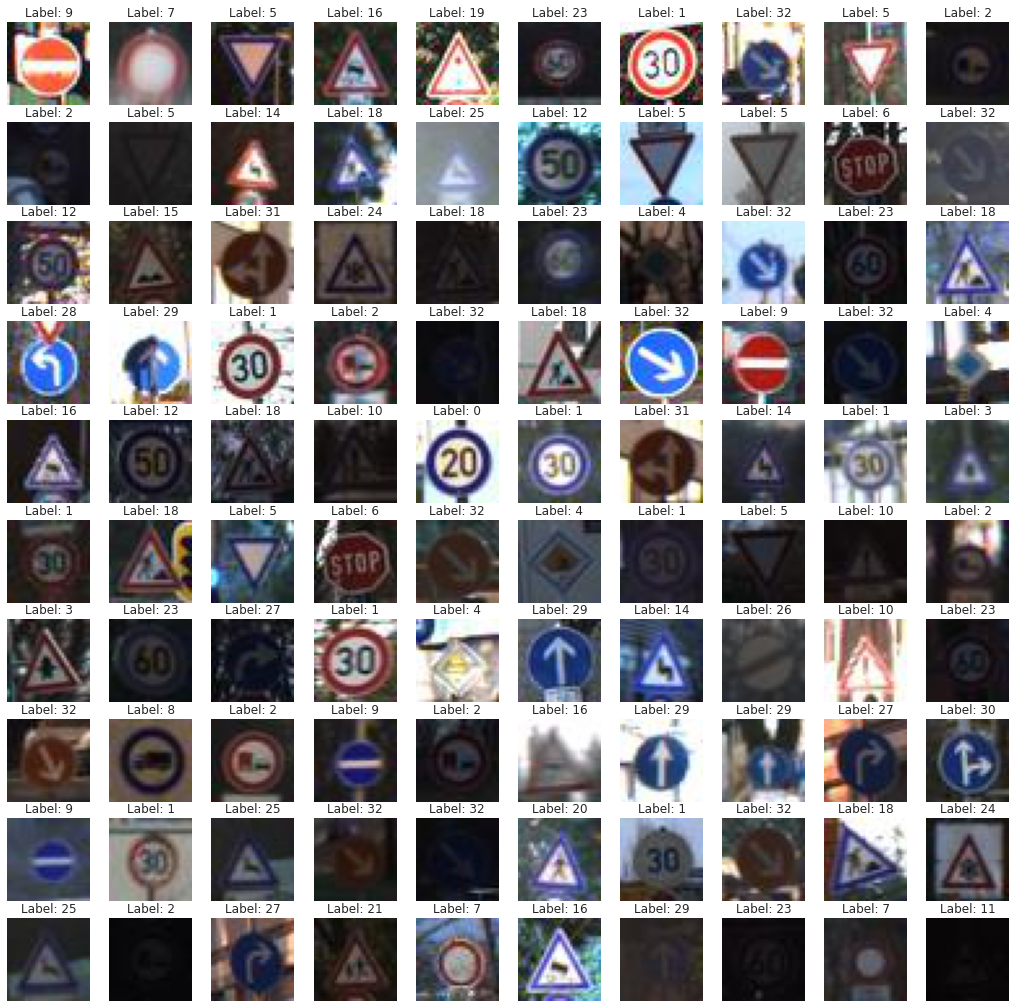

In [16]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X.shape[0])
    ax.imshow(X[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Label: '+str(np.argmax(y[r])))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [18]:
print("Train Shape: {}\nTest Shape : {}".format(X_train.shape, X_test.shape))

Train Shape: (43347, 32, 32, 3)
Test Shape : (10837, 32, 32, 3)


## Customising ResNet50 model

In [19]:
resnet = ResNet50(weights= None, include_top=False, input_shape= (img_rows,img_cols,img_channels))

In [20]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation= 'softmax')(x)
model = Model(inputs = resnet.input, outputs = predictions)

In [21]:
# model.summary()

In [22]:
# plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

## Compiling the Model

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Creating Callbacks

In [24]:
model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')

## Fitting Model with Data

In [26]:
n_epochs = 50
# b_size = 32
b_size = 1000

history =  model.fit(X_train, y_train,  batch_size = b_size, epochs = n_epochs, verbose = 1, 
              validation_data = (X_test, y_test), callbacks = [model_check, early, reduce_lr, csv_logger])

Epoch 1/50
44/44 [==============================] - 65s 520ms/step - loss: 3.5201 - accuracy: 0.1964 - val_loss: 3.7477 - val_accuracy: 0.0816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
44/44 [==============================] - 16s 360ms/step - loss: 1.2484 - accuracy: 0.6482 - val_loss: 3.1848 - val_accuracy: 0.1609
Epoch 3/50
44/44 [==============================] - 16s 370ms/step - loss: 0.4188 - accuracy: 0.8798 - val_loss: 2.8319 - val_accuracy: 0.1727
Epoch 4/50
44/44 [==============================] - 17s 381ms/step - loss: 0.6114 - accuracy: 0.8458 - val_loss: 2.4784 - val_accuracy: 0.2887
Epoch 5/50
44/44 [==============================] - 17s 387ms/step - loss: 0.1727 - accuracy: 0.9510 - val_loss: 1.5211 - val_accuracy: 0.5574
Epoch 6/50
44/44 [==============================] - 17s 381ms/step - loss: 0.0790 - accuracy: 0.9794 - val_loss: 0.5280 - val_accuracy: 0.8330
Epoch 7/50
44/44 [==============================] - 17s 377ms/step - loss: 0.0857 - accuracy: 0.9794 - val_loss: 0.5983 - val_accuracy: 0.8209
Epoch 8/50
44/44 [==============================] - 17s 378ms/step - loss: 0.0679 - accuracy: 0.9800 - val_loss: 0.6630 - val_accuracy: 0.8183

We had an early stopping in epoch 15

In [27]:
# Saving the model
model.save('TSC_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [28]:
loss, acc = model.evaluate(X_test, y_test)
print('Accuracy: ', acc, '\nLoss    : ', loss)

339/339 [==============================] - 6s 15ms/step - loss: 0.0793 - accuracy: 0.9783
Accuracy:  0.9783150553703308 
Loss    :  0.07928694039583206


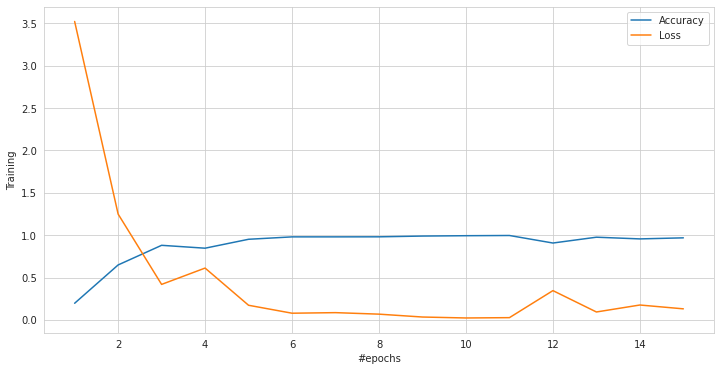

In [29]:
q = len(list(history.history['loss']))
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Loss')
plt.xlabel('#epochs')
plt.ylabel('Training')
plt.legend();

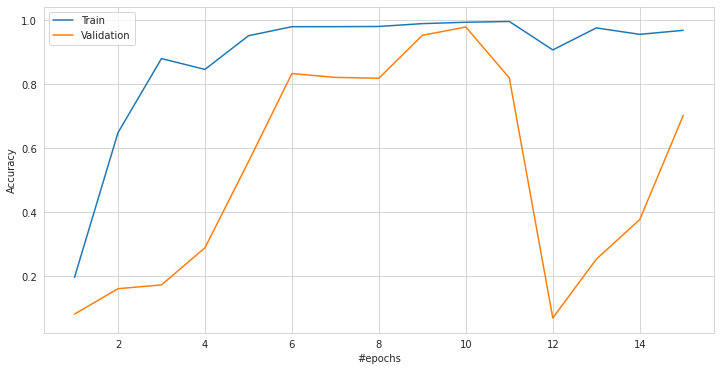

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_accuracy'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Accuracy')
plt.legend();

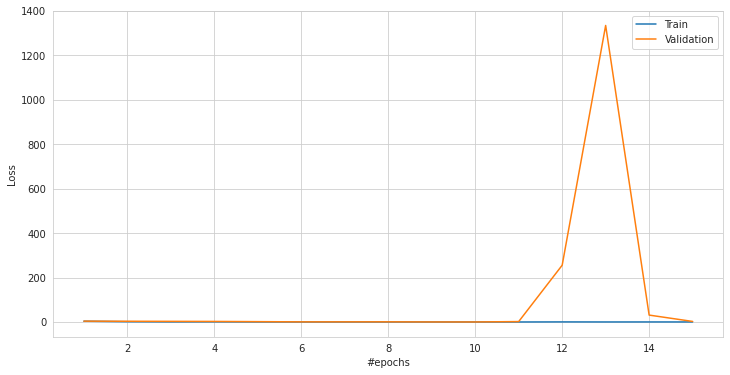

In [31]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = range(1, 1+q), y = history.history['loss'], label = 'Train')
sns.lineplot(x = range(1, 1+q), y = history.history['val_loss'], label = 'Validation')
plt.xlabel('#epochs')
plt.ylabel('Loss')
plt.legend();

## Predict class labels of the test data

In [32]:
%%time
pred = np.argmax(model.predict(X_test), axis = 1)

CPU times: user 4.51 s, sys: 75.9 ms, total: 4.59 s
Wall time: 5.85 s


## Classification Report

In [39]:
# labels = [class_labels[i] for i in range(43)]
# print(classification_report(np.argmax(y_test, axis = 1), pred, target_names = labels))

## Confusion Matrix

In [ ]:
# cmat = confusion_matrix(np.argmax(y_test, axis=1), pred)
# plt.figure(figsize=(16,16))
# sns.heatmap(cmat, annot = True, cbar = False, cmap='Paired', fmt="d", xticklabels=labels, yticklabels=labels);

## Finally, Lets see the predictions of unseen data

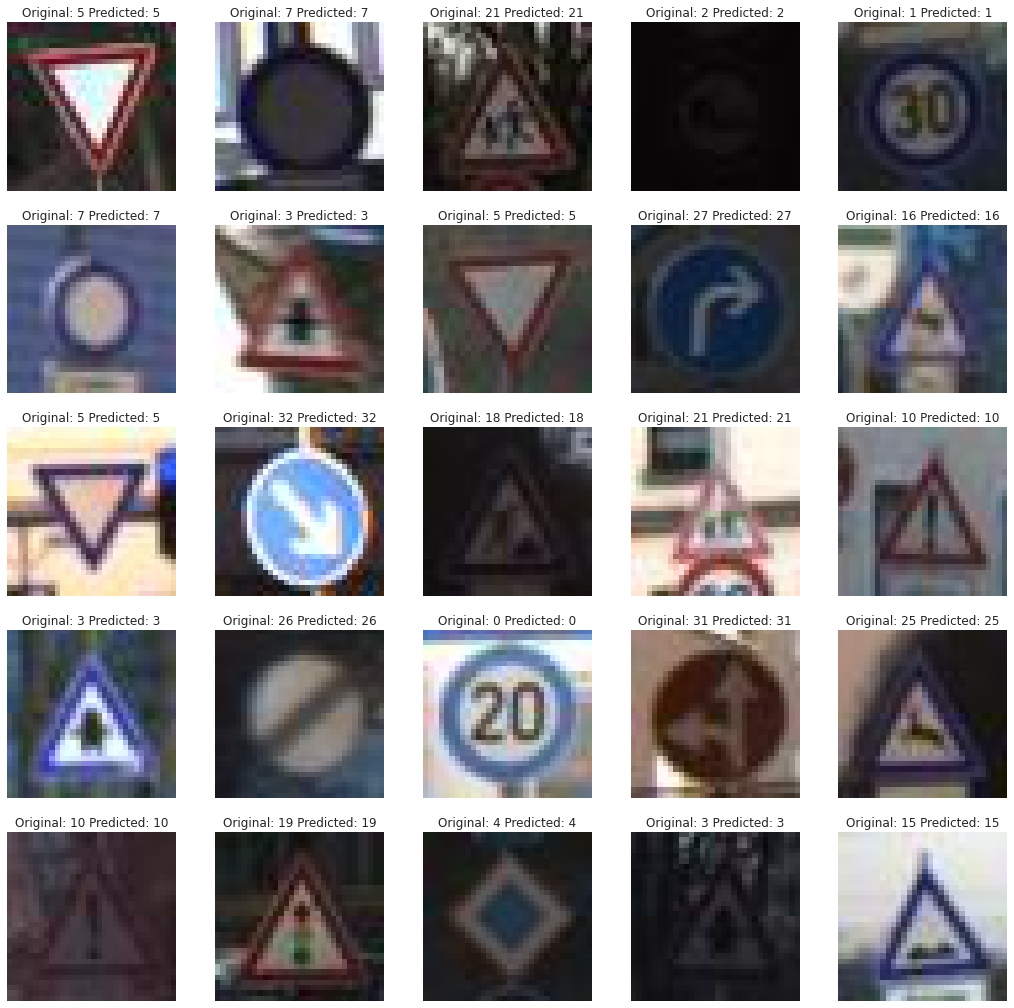

In [38]:
fig, axes = plt.subplots(5,5, figsize=(18,18))
for i,ax in enumerate(axes.flat):
    r = np.random.randint(X_test.shape[0])
    ax.imshow(X_test[r].astype('uint8'))
    ax.grid(False)
    ax.axis('off')
    ax.set_title('Original: {} Predicted: {}'.format(np.argmax(y_test[r]), np.argmax(model.predict(X_test[r].reshape(1, 32, 32, 3)))))
